# Laboratório 4

Neste laboratório, vamos aplicar um pouco da teoria e prática que vimos ao longo da disciplina.

A ideia principal é que vamos trabalhar um pouco mais com os novos classificadores vistos comparação de classificadores e importância de características.

Assim como nos Laboratório 01, 02 e 03, vamos utilizar o conjunto de dados ``College``, disponível [aqui](https://www.statlearning.com/resources-python).

Só para lembrar, o conjunto de dados contém informações sobre várias faculdades e universidades dos Estados Unidos. O significado de cada informação não é essencial para este exercício. Mas alguns exemplos de informações contidas no conjunto de dados são:

- `Private`: Indica se a instituição é pública ou privada
- `Apps`: Número de aplicações recebidas
- `Accept`: Número de aplicações aceitas
- `Enroll`: Número de novos alunos matriculados
- `Top10perc`: Percentual de novos alunos do top 10% de turmas do ensino médio
- `Top25perc`: Percentual de novos alunos do top 25% de turmas do ensino médio
- ...

## Obtenção dos dados

Para obter o conjunto de dados, execute o comando abaixo. O arquivo ``College.csv`` será diretamente acessível por meio desse *notebook*.

**Observação:** caso a sessão do *notebook* seja interrompida, será necessário baixar o conjunto de dados novamente.

In [2]:
import requests

url = "https://www.statlearning.com/s/College.csv"
response = requests.get(url)

with open("College.csv", "wb") as file:
    file.write(response.content)

**ATENÇÃO:** você não deve remover ou adicionar células no restante deste *notebook*.

Sempre escreva suas respostas nas células indicadas!

## Leitura e Preparação dos Dados [Não vale pontos, mas é necessário]

Repita a Parte I do Laboratório 01. Ou seja, prepare o conjunto de dados seguindo as instruções dos Itens 1.1 a 1.7 daquele Laboratório.

In [30]:
# Escreva sua resposta aqui
# Escreva sua resposta aqui
import pandas as pd
df=pd.read_csv('College.csv')
def load_data(df):
    df = df.rename(columns={"Unnamed: 0": "College"})
    df = df.set_index("College")
    df['Good School'] = df['Top10perc'].apply(lambda x: 1 if x > 25 else 0)
    df['Private'] = df['Private'].apply(lambda x: 1 if x == 'Yes' else 0)
    y=df['Good School']
    df=df.drop(columns=['Top10perc','Top25perc','Good School'])
    return y,df
y,df = load_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 777 entries, Abilene Christian University to York College of Pennsylvania
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Private      777 non-null    int64  
 1   Apps         777 non-null    int64  
 2   Accept       777 non-null    int64  
 3   Enroll       777 non-null    int64  
 4   F.Undergrad  777 non-null    int64  
 5   P.Undergrad  777 non-null    int64  
 6   Outstate     777 non-null    int64  
 7   Room.Board   777 non-null    int64  
 8   Books        777 non-null    int64  
 9   Personal     777 non-null    int64  
 10  PhD          777 non-null    int64  
 11  Terminal     777 non-null    int64  
 12  S.F.Ratio    777 non-null    float64
 13  perc.alumni  777 non-null    int64  
 14  Expend       777 non-null    int64  
 15  Grad.Rate    777 non-null    int64  
dtypes: float64(1), int64(15)
memory usage: 103.2+ KB


Ao final da preparação, o *Data Frame* deve se parecer com o mostrado abaixo.

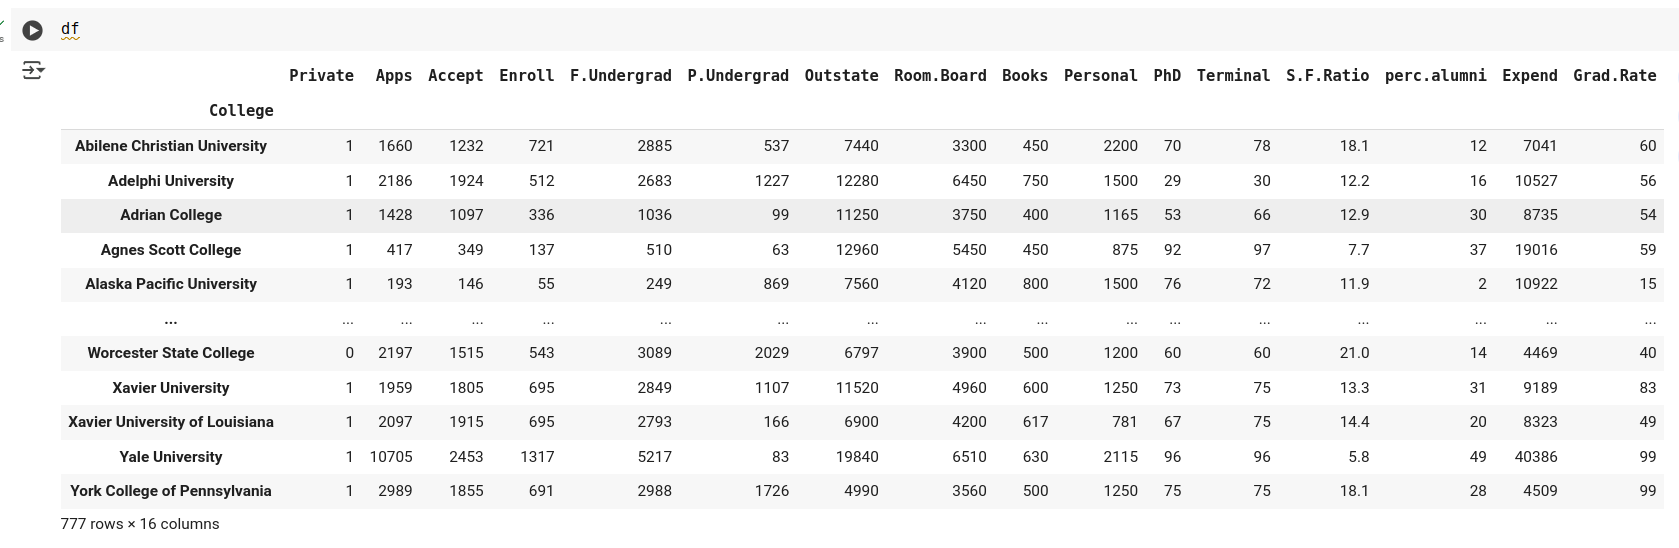

## Parte 1: KNN, Floresta Aleatória e SVM [35 pontos - Todos os itens têm o mesmo valor]

Assim como nos Laboratórios 01, 02 e 03, a tarefa de predição aqui será prever a variável `y` em função dos dados contidos no *Data Frame* resultante na parte anterior do laboratório.

Ou seja, o objetivo é criar um modelo para classificar se uma instituição de ensino é uma `Good School` ou não.

### Divisão em conjuntos de treinamento e teste.

Divida o conjunto de dados em porções distintas para treinamento e avaliação do classificador.

25% do conjunto de dados deve ser retido para testes.

Essa mesma divisão deverá ser utilizada no restante do laboratório.

O Código fornecido abaixo realiza essa separação para você e não deve ser alterado.

In [31]:
# não modifique esse código.

from sklearn.model_selection import train_test_split

X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

### Transformação dos dados

Antes de continuar, você deve aplicar a transformação por reescala nos dados. Lembre, o `scaler` deve ser ajustado ao conjunto de treinamento e posteriormente aplicado ao conjunto de teste.

**Atenção:**
- O conjunto de treinamento transformado deve ser armazenado na variável `X_train_scaled`.
- Similarmente, o conjunto de teste transformado, deve ser armazenado na variável `X_test_scaled`.

In [6]:
# Escreva sua resposta aqui
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


class ClassifierOptimizer:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.scaler = None
        self.scaled = False # Flag para indicar se os dados foram escalados
        self.cv=5 # Número de folds para validação cruzada
        # Classificadores a serem otimizados
        self.classifiers = {
        'KNN': KNeighborsClassifier(),
        'RandomForest': RandomForestClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42)
        }
        # Parâmetros a serem testados para cada classificador
        self.param_grids = {
            'KNN': {'n_neighbors': np.arange(1, 31)},
            'RandomForest': {
                'n_estimators': [10, 100, 500, 1000],
                'max_depth': np.arange(2, 31, 2)
            },
            'SVM': {'C': np.logspace(-3, 3, 30), 'kernel': ['linear', 'rbf']}
        }
        self.best_estimators = {}
        self.best_hyperparameters = {}
        self.predictions_optimized = {}
        self.class_predictions = {}

    def scale_data(self):
        """
        Aplica o MinMaxScaler aos dados de treino e teste.
        """
        self.scaler = MinMaxScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        self.scaled = True # Flag para indicar que os dados foram escalados
        print("Dados escalados com sucesso!")

    def optimize_classifiers(self):
        """
        Otimiza os classificadores usando GridSearchCV.
        """
        X_train = self.X_train_scaled if self.scaled else self.X_train # Usa dados escalados se disponíveis, caso contrário usa dados padrão
        for classifier_name, classifier in self.classifiers.items():
            print(f"\nOtimizando {classifier_name}...")
            # GridSearchCV para encontrar os melhores hiperparâmetros
            grid_search = GridSearchCV(
                classifier, 
                self.param_grids[classifier_name], 
                cv=self.cv, 
                n_jobs=-1, # Usa todos os núcleos do processador
                verbose=1 # Mostra mensagens de progresso
            )
            grid_search.fit(X_train, self.y_train)
            
            self.best_estimators[classifier_name] = grid_search.best_estimator_# Salva os melhores classificadores treinados de cada tipo de classificador
            self.best_hyperparameters[classifier_name] = grid_search.best_params_# Salva os melhores hiperparâmetros
            print(f"Melhores parâmetros para {classifier_name}: {grid_search.best_params_}")

    def print_best_hyperparameters(self):
        """
        Imprime os melhores hiperparâmetros encontrados para cada classificador.
        """
        if not self.best_hyperparameters:
            raise ValueError("Chame optimize_classifiers() antes de imprimir os hiperparâmetros.")
        
        print("\nMelhores Hiperparâmetros:")
        for classifier_name, params in self.best_hyperparameters.items():
            print(f"{classifier_name}: {params}")

    def evaluate_classifiers(self):
        """
        Avalia os classificadores nos dados de teste.
        """
        X_train = self.X_train_scaled if self.scaled else self.X_train
        X_test = self.X_test_scaled if self.scaled else self.X_test
        
        if not self.best_estimators: # Se os classificadores não foram otimizados (best_estimators vazio)
            print("Usando classificadores padrão (sem otimização).")
            self.best_estimators = self.classifiers # Usa os classificadores padrão
            for classifier_name, classifier in self.classifiers.items():
                classifier.fit(X_train, self.y_train)
        
        for classifier_name, best_estimator in self.best_estimators.items(): # faz previsões para cada classificador
            y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]
            self.predictions_optimized[classifier_name] = y_pred_proba
            
            y_pred = best_estimator.predict(X_test)
            self.class_predictions[classifier_name] = y_pred

    def print_classification_reports(self):
        """
        Imprime relatórios de classificação para todos os classificadores.
        """
        if not self.class_predictions:
            raise ValueError("Chame evaluate_classifiers() antes de gerar relatórios.")
        
        for classifier_name, y_pred in self.class_predictions.items():
            print(f"\n{classifier_name}\n{'-'*30}")
            print(classification_report(self.y_test, y_pred))

    def print_auc_scores(self):
        """
        Imprime as métricas AUC para todos os classificadores.
        """
        if not self.predictions_optimized:
            raise ValueError("Chame evaluate_classifiers() antes de calcular AUC.")
        
        for classifier_name, y_pred_proba in self.predictions_optimized.items():
            fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba) # Calcula FPR e TPR
            roc_auc = auc(fpr, tpr) # Calcula AUC
            print(f"AUC ({classifier_name}): {roc_auc:.4f}")

    def plot_roc_curve(self):
        """
        Plota todas as curvas ROC em um único gráfico.
        """
        if not self.predictions_optimized:
            raise ValueError("Chame evaluate_classifiers() antes de plotar curvas ROC.")
        
        plt.figure(figsize=(10, 8))
        for classifier_name, y_pred_proba in self.predictions_optimized.items():
            fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
        plt.title('Curvas ROC Comparativas')
        plt.xlabel('Taxa de Falsos Positivos')
        plt.ylabel('Taxa de Verdadeiros Positivos')
        plt.legend(loc='lower right')
        plt.show()

optimizer = ClassifierOptimizer(X_train, y_train, X_test, y_test)
optimizer.scale_data()


Dados escalados com sucesso!


### Item 1.1

Treine os Classificadores [KNN](https://scikit-learn.org/1.6/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [Floresta Aleatória](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) e [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) no conjunto de dados acima.

Para isso, você deve utilizar o módulo [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Aqui, você deve fazer o processo completo. Utilizar os dados transformados (por reescala) e realizar seleção de hiperparâmetros via validação cruzada.

Para cada um dos três classificadores, considere os seguintes conjuntos de hiperparâmetros candidatos:
- $k$ do **KNN** -- $k \in \{1, 2, 3, \dots, 30\}$.
- número de estimadores e profundidade máxima da **Floresta Aleatória** -- considere os valores $\{10, 100, 500\}$ para o número de estimadores e $\{2, 4, 6, \dots, 30\}$ para profundidade máxima.
- $C$ e $\gamma$ do **SVM** -- comumente, para isso, utiliza-se valores espaçados exponencialmente. Assim, utilize a função [`logspace`](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html) da biblioteca `numpy` para criar 10 valores espaçados exponencialmente de 0.0001 a 10000 (tanto para $C$ quanto para $\gamma$).

In [7]:
# Escreva sua resposta aqui
optimizer.optimize_classifiers()
optimizer.evaluate_classifiers()


Otimizando KNN...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros para KNN: {'n_neighbors': 10}

Otimizando RandomForest...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Melhores parâmetros para RandomForest: {'max_depth': 6, 'n_estimators': 500}

Otimizando SVM...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Melhores parâmetros para SVM: {'C': 22.122162910704503, 'kernel': 'rbf'}


### Item 1.2

Para cada classificador treinado, imprima o [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) do classificador relativo aos rótulos preditos no conjunto de teste.


KNN
------------------------------
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       107
           1       0.88      0.59      0.71        88

    accuracy                           0.78       195
   macro avg       0.81      0.76      0.77       195
weighted avg       0.80      0.78      0.77       195


RandomForest
------------------------------
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       107
           1       0.85      0.69      0.76        88

    accuracy                           0.81       195
   macro avg       0.81      0.80      0.80       195
weighted avg       0.81      0.81      0.80       195


SVM
------------------------------
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       107
           1       0.83      0.70      0.76        88

    accuracy                           0.80       195
   macro av

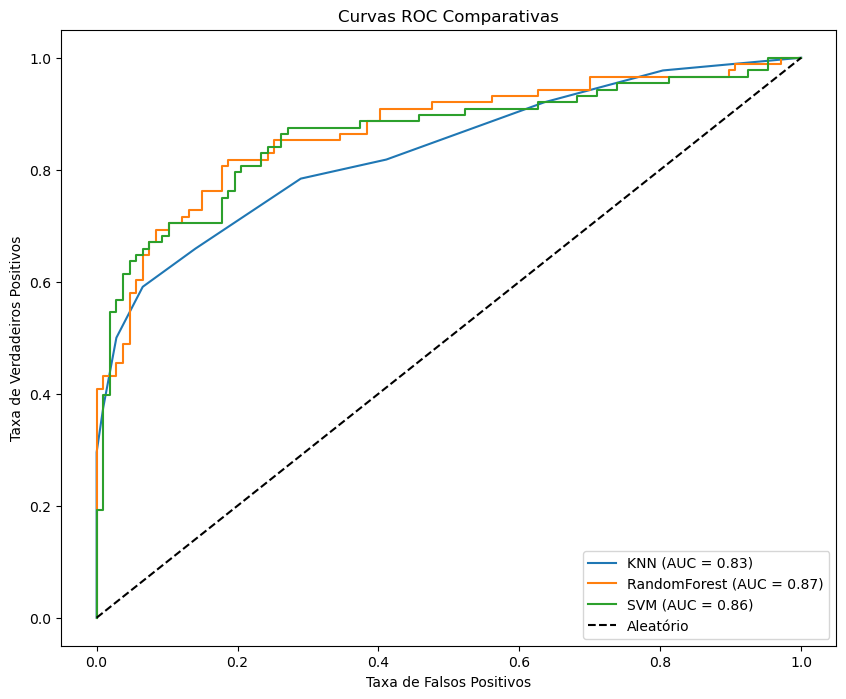

In [ ]:
# Escreva sua resposta aqui
optimizer.print_classification_reports()
optimizer.print_best_hyperparameters()
optimizer.print_auc_scores()
optimizer.plot_roc_curve()

### Item 1.3

Com base nos resultados acima, o SVM teve desempenho melhor do que a Floresta Aleatória e o KNN?

**Resposta:** [SVM teve resultado melhor que KNN mas bem similar a Floresta Aleatória]

## Parte 2 - Importância de Características [35 pontos - Todos os itens têm o mesmo valor]

### Item 2.1

Compute a [informação mútua](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) de entre cada característica e o rótulo (classe) do conjunto de dados.

Apresente os resultados em um gráfico de barras:
- O eixo $X$ deve ter todas as características (com os nomes) em ordem decrescente de informação mútua;
- O eixo $Y$ deve ser referente ao valor da informação mútua.

C:\Users\f\AppData\Local\Temp\ipykernel_10480\1248148509.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_mi, y=sorted_features, palette='viridis')


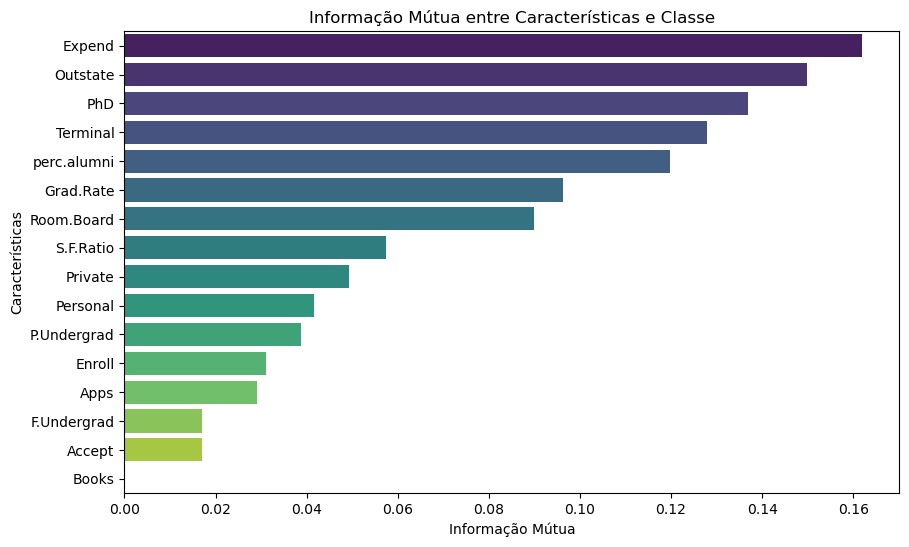

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

def plot_mutual_info(X, y, feature_names):
    """
    Calcula e plota a informação mútua entre as características e o rótulo.
    
    Parâmetros:
    - X: Array ou DataFrame com as características
    - y: Série ou array com os rótulos (classe)
    - feature_names: Lista ou array com os nomes das características
    """
    # Calcular a informação mútua
    mi = mutual_info_classif(X, y, random_state=42)
    
    # Ordenar os valores e características
    sorted_indices = np.argsort(mi)[::-1]
    sorted_mi = mi[sorted_indices]
    sorted_features = np.array(feature_names)[sorted_indices]
    
    # Criar gráfico
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_mi, y=sorted_features, palette='viridis')
    plt.xlabel('Informação Mútua')
    plt.ylabel('Características')
    plt.title('Informação Mútua entre Características e Classe')
    plt.show()

plot_mutual_info(df, y, df.columns)


### Item 2.2

De acordo o resultado do Item 2.1, quais as características mais importantes no problema de predição?


**Resposta:** [Os que tem maior valor de informação mútua: perc. alumni, terminal, phd, outstate, expend]

### Item 2.3

Compute a importância das características para o problema de predição utilizando o classificador [Floresta Aleatória](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_).

Apresente os resultados em um gráfico de barras:

O eixo $X$ deve ter todas as características (com os nomes) em ordem decrescente de importância;
O eixo $Y$ deve ser referente ao valor da importância.

C:\Users\f\AppData\Local\Temp\ipykernel_10480\302041418.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sorted_importances, y=sorted_features, palette='viridis')


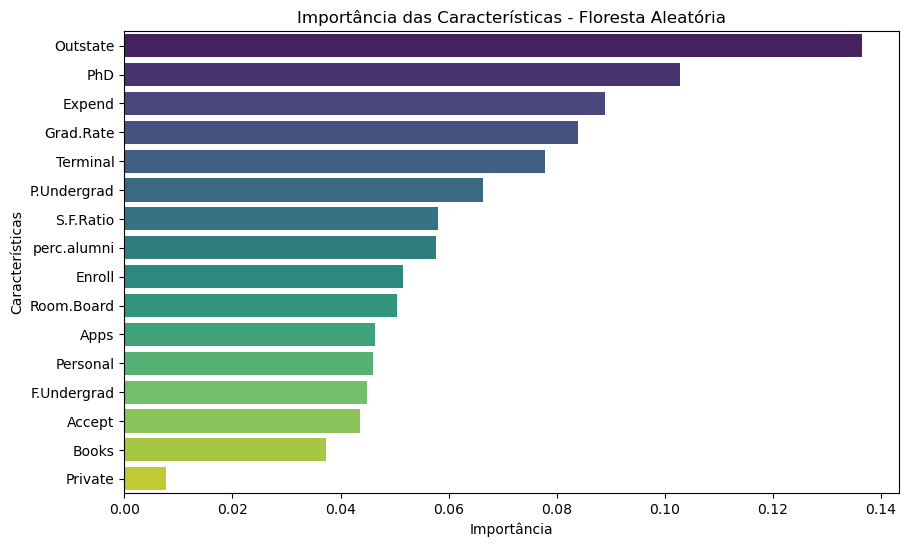

In [ ]:
# Escreva sua resposta aqui
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

def plot_feature_importance(X, y, feature_names):
    """
    Calcula e plota a importância das características usando Floresta Aleatória.
    
    Parâmetros:
    - X: DataFrame om as características
    - y: Array com os rótulos (classe)
    - feature_names: Lista ou array com os nomes das características
    """
    X = df.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled =scaler.transform(X_test)
    # Treinar o modelo de Floresta Aleatória
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Obter as importâncias das características
    importances = model.feature_importances_
    
    # Ordenar as características por importância
    sorted_indices = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_indices]
    sorted_features = np.array(feature_names)[sorted_indices]
    
    # Criar o gráfico de barras horizontais
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=sorted_importances, y=sorted_features, palette='viridis')
    plt.xlabel('Importância')
    plt.ylabel('Características')
    plt.title('Importância das Características - Floresta Aleatória')
    plt.show()

plot_feature_importance(df, y, feature_names=df.columns)

### Item 2.4

De acordo o resultado do Item 2.3, quais as características mais importantes no problema de predição?

Esse resultado é similar ao obtido no Item 2.1? Comente as semelhanças e diferenças.


**Resposta:** [As características mais importantes são: Outstate, PhD, Expend, Grad. Rate e Terminal. Embora os valores estajam próximos, a ordem de importância das colunas está diferente do resultado anterior (ex: a mais relavante era Expend, agora é Outstate)]

### Item 2.5

Utilizando [SHAP](https://shap.readthedocs.io/en/latest/), faça o gráfico [`Beeswarm`](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html).

Consulte o material da disciplina para construir o gráfico de forma correta. É importante que o nome das características estejam no eixo $Y$.

**Observação:** é importante instalar o módulo `shap` antes. O código para isso está na célula abaixo.

In [ ]:
# não mude nada aqui

#!pip install shap

   ---------------------------------------- 0.0/531.1 kB ? eta -:--:--
   ---------------------------------------  524.3/531.1 kB ? eta -:--:--
   ---------------------------------------- 531.1/531.1 kB 1.3 MB/s eta 0:00:00


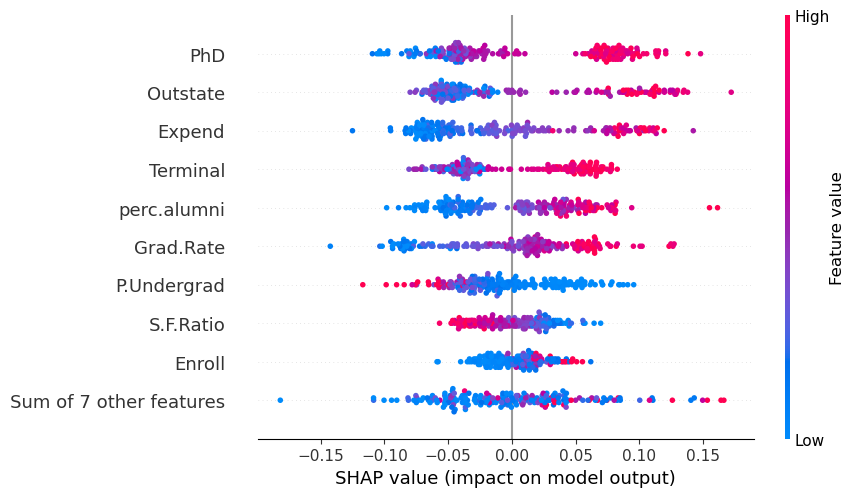

In [22]:
# Escreva sua resposta aqui
import shap
features = df.columns.tolist()
model = RandomForestClassifier(n_estimators = 100)
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=features
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=features
)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_scaled)[:,:,1]
shap.plots.beeswarm(shap_values)

### Item 2.6

Comente os resultados do gráfico construído no Item 2.5.

Quais são as características mais importantes para o problema de predição? Essas características são as mesmas identificadas no Itens 2.1 e 2.3?

Quais outros fatos importantes sobre o modelo podem ser extraídos da Figura?

**Resposta:** [As características com maior impacto absoluto nos valores SHAP (maior dispersão ao longo do eixo horizontal) são, em ordem decrescente de importância: PhD,Outstate, Expend, Terminal, perc.alumni e Grad.Rate. As varáveis mais relevantes continuam as mesmas, porém com pequenas alterações. Além de identificar as variáveis mais relevantes, também podemos ver o quanto essas variáveis contribuem para previsão positiva (1) ou negativa (2) de acordo com os valores da variável]

##Parte 3 - Comparação de Modelos com Testes de Hipótese [30 pontos - Todos os itens têm o mesmo valor]

### Item 3.1

Nessa última parte do laboratório, vamos atacar duas perguntas:

- Para o problema de classificação sendo estudado, o KNN é equivalente à Floresta Aleatória?
- Para o problema de classificação sendo estudado, a Floresta Aleatória é equivalente ao SVM?

Para responder essas perguntas, iremos utilizar o Teste $t$ pareado (Vide material da disciplina). Para isso, você deverá repedir o experimento da Parte I 50 vezes. Em cada repetição:

1. Realize uma divisão do conjunto de dados em porções de treinamento e teste. Nesse momento, é importante não fixar o parâmetro `random_state` do método `train_test_split`.

2. Ajustar um `scaler` para aplicar a transformação por reescala nos dados. Lembre, o `scaler` deve ser ajustado nos dados de treinamento.

3. Treinar os classificadores KNN, Floresta Aleatória e SVM na porção dos dados reservada para treinamento. Nesse passo, você deve utilizar os hiperparâmetros selecionados no treinamento realizado no Item 1.1.

4. Utilizar os modelos treinados para prever os rótulos dos elementos do conjunto de teste.

5. Computar o $F_1$-score dos três classificadores e armazenar esses valores.

In [33]:
from sklearn.metrics import f1_score

scores = []
scaler = MinMaxScaler()
for i in range(50):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled =scaler.transform(X_test)
  # Clssificador 1
  model = RandomForestClassifier(n_estimators = 10)
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)
  score1 = f1_score(y_test, y_pred, average = 'weighted')


  # Classificador 2
  model = RandomForestClassifier(n_estimators= 500, max_depth= 6)
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)
  score2 = f1_score(y_test, y_pred, average = 'weighted')

  # Classificador 3
  model = SVC(C= 22.122162910704503, kernel= 'rbf')
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)
  score3 = f1_score(y_test, y_pred, average = 'weighted')

  scores.append([score1, score2,score3])

df = pd.DataFrame(scores, columns = ['Classificador 1', 'Classificador 2','Classificador 3'])
df.describe()

,Classificador 1,Classificador 2,Classificador 3
count,50.000000,50.000000,50.000000
mean,0.768391,0.789452,0.780568
std,0.026372,0.021858,0.022650
min,0.719805,0.737978,0.727629
25%,0.751558,0.776753,0.761054
50%,0.764366,0.790481,0.781849
75%,0.787456,0.800094,0.793157
max,0.835385,0.844691,0.827032


### Item 3.2

Faça um gráfico Box-Plot para os $F_1$-scores dos três classificadores. Ou seja, uma única figura com um box-plot para cada classificador.

Text(0, 0.5, '$F_1$-Score')

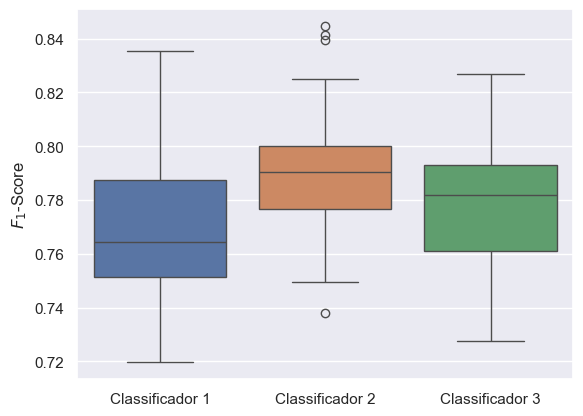

In [37]:
# Escreva sua resposta aqui

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

sns.boxplot(data = df)
plt.ylabel(r'$F_1$-Score')

### Item 3.3

Faça um gráfico de barras, com intervalo de confiança de 95%, para os  $F_1$-scores dos três classificadores. Ou seja, uma única figura com uma barra para cada classificador.

Text(0, 0.5, '$F_1$-Score (Média e Intervalo de Conf.)')

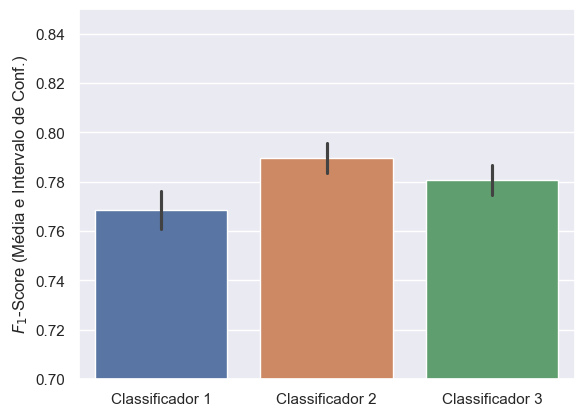

In [39]:
# Escreva sua resposta aqui

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

sns.barplot(data = df)
plt.ylim((0.7, .85))
plt.ylabel(r'$F_1$-Score (Média e Intervalo de Conf.)')

### Item 3.4

Com base nos gráficos dos Itens 3.2 e 3.3:
1. Há alguma evidência de que o KNN seja melhor, pior ou equivalente à Floresta Aleatória?
2. Há alguma evidência de que a Floresta Aleatória seja melhor, pior ou equivalente ao SVM?

**Resposta:** [Tendo em vista o intervalo de confiança da média do F1-Score, Random Forest apresenta o melhor resultado, seguido de SVM e KNN]

### Item 3.5

Utilize o teste $t$ pareado para comparar o KNN com a Floresta Aleatória. Você deve imprimir o $p$-valor do teste.

In [40]:
# Escreva sua resposta aqui
from scipy import stats

r = stats.ttest_rel(df['Classificador 1'], df['Classificador 2'], alternative = 'less')
r.pvalue

3.210542213086297e-09

### Item 3.6

Com base no resultado do Item 3.5, o desempenho do KNN (considerando $F_1$-score é equivalente ao desempenho da Floresta Aleatória?

**Resposta:** [Com base nesse resultado, o "Classificador 2" parece ser melhor do que o "Classificador 1" em termos de desempenho, dado que a diferença observada é estatisticamente significativa.]

### Item 3.7

Utilize o teste $t$ pareado para comparar a Floresta Aleatória com o SVM. Você deve imprimir o $p$-valor do teste.

In [43]:
# Escreva sua resposta aqui
from scipy import stats

r = stats.ttest_rel(df['Classificador 2'], df['Classificador 3'], alternative = 'less')
r.pvalue

0.9985564321036051

### Item 3.8

Com base no resultado do Item 3.7, o desempenho da Floresta Aleatória (considerando  $F_1$-score é equivalente ao desempenho do SVM?

**Resposta:** [O "Classificador 2" e o "Classificador 3" possuem desempenho similar, pois a diferença entre as suas médias não é significativa de acordo com o teste realizado.]